In [1]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import numpy as np
# Load data

#data = pd.read_csv('data.csv', delimiter=';')
data = pd.read_csv('oversample.csv')
# Extract features and target
X = data.drop(columns=['Target'])
y = data['Target']

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adjust class weights - useful for imbalanced classes
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)

In [2]:
#### GridSearch with 3 folds
from sklearn.model_selection import GridSearchCV
estimator = xgb.XGBClassifier(
    objective= 'multi:softprob',
    random_state=42
)
parameters = {
    'max_depth': range (0, 12, 2),
    'n_estimators': [100,200,400],
    'learning_rate': [0.1, 0.01, 0.05],

}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1_macro',
    cv = 2,
    verbose=True
)
grid_search.fit(X_train,y_train)


Fitting 2 folds for each of 54 candidates, totalling 108 fits


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softprob', ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(0, 12, 2),
                         'n_estimators': [100, 200, 400]},
             scoring='f1_macro', verbose=True)

In [3]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 400}

In [4]:
final_model = xgb.XGBClassifier(**grid_search.best_params_)
final_model.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_model.predict(X_test)
predictions = [round(value) for value in y_pred]
final_accuracy = accuracy_score(y_test, predictions)
print("Final Model Accuracy: %.2f%%" % (final_accuracy * 100.0))

Final Model Accuracy: 90.72%


In [5]:
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.88      0.91       437
           1       0.86      0.97      0.91       439
           2       0.93      0.88      0.90       450

    accuracy                           0.91      1326
   macro avg       0.91      0.91      0.91      1326
weighted avg       0.91      0.91      0.91      1326



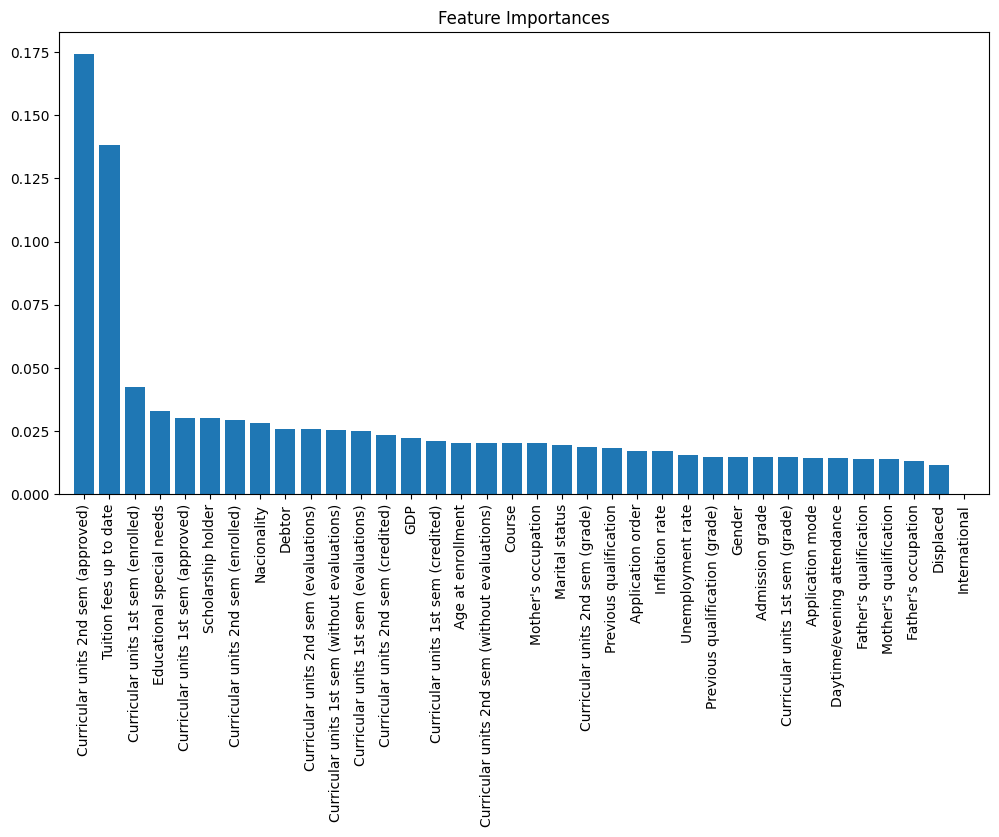

In [6]:
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

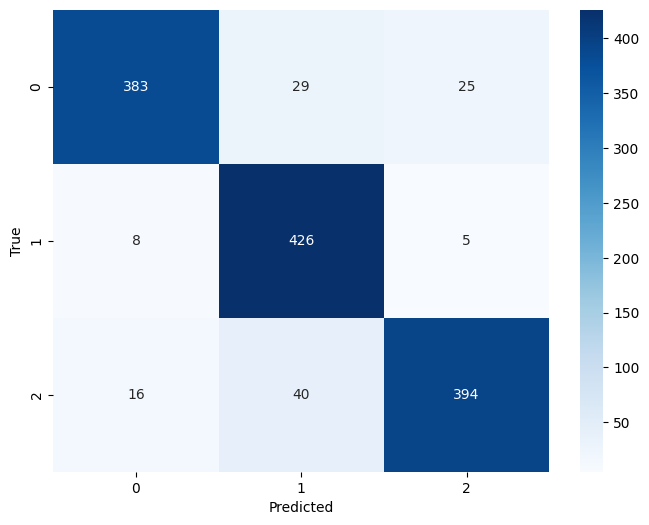

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
